In [ ]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from keras.callbacks import CSVLogger
from keras.metrics import Precision, Recall
from keras.preprocessing.text import one_hot
from keras.models import Sequential, load_model
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.layers import Dense, Embedding, GlobalMaxPool1D, Conv1D, Dropout, SpatialDropout1D, MaxPooling1D, Flatten

!pip install transformers
!pip install sentencepiece
from transformers import XLNetTokenizer, TFXLNetModel, PreTrainedTokenizerBase


     |████████████████████████████████| 4.2 MB 12.6 MB/s 
     |████████████████████████████████| 84 kB 3.2 MB/s 
     |████████████████████████████████| 596 kB 41.0 MB/s 
     |████████████████████████████████| 6.6 MB 43.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 12.0 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir train_local
# !wget /content/drive/MyDrive/labeled_data.zip
!unzip /content/drive/MyDrive/labeled_data.zip -d /content/train_local

Mounted at /content/drive
Archive:  /content/drive/MyDrive/labeled_data.zip
  inflating: /content/train_local/Dynamically_Generated_Hate_Dataset_v0.2.3.csv  
  inflating: /content/train_local/labeled_data.csv  


In [ ]:
import nltk
import matplotlib.pyplot as plt

from re import sub
from pandas import DataFrame
from tabulate import tabulate
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from typing import Union, List, Tuple
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pandas.io.parsers import TextFileReader


nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('omw-1.4')
nltk.download('punkt')
__STOPWORDS = stopwords.words("english")
STEMMER = PorterStemmer()
LEMMATIZER = WordNetLemmatizer()


def process_data(text: str, do_stemming: bool = False, do_lemmas: bool = False, do_lowercase: bool = False) -> str:
    """
    @param text: The text to process. It will remove the money amounts, retweets, links,
                 hashtags, punctuation and it will lowercase all the words
    @param do_stemming: Steam words to have less in vocabulary if set to true
    @param do_lowercase: Lowercase input text if set to true
    @param do_lemmas: Lemmatize word to be at a dictionary representation if true
    @return: The new processed text as a list of words
    """
    text = sub(r"\$\w*", "", text)
    text = sub(r"(RT)+", "", text)
    text = sub(r"(lt)+", "", text)
    text = sub(r"(gt)+", "", text)
    text = sub(r"@[a-zA-Z0-9\_]+", "", text)
    text = sub(r"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)", "", text)
    text = sub(r"#", "", text)
    text = sub(r"\d+", "", text)
    text = sub("[^A-Za-z0-9]+", " ", text)  # also removes special characters since they are not alphanumeric
    if do_lowercase:
        text = text.lower()

    # tokenized_data = __TOKENIZER.tokenize(text)
    tokenized_data = word_tokenize(text)
    processed_data = []

    for word in tokenized_data:
        if word not in __STOPWORDS and word not in punctuation:
            if do_stemming and not do_lemmas:
                word = STEMMER.stem(word)
            elif do_lemmas and not do_stemming:
                word = LEMMATIZER.lemmatize(word)
            elif do_lemmas and do_stemming:
                raise ValueError(
                    f"Can't do both lemmatizing and stemming. Values for do_lemmas={do_lemmas} "
                    f"and do_stemming={do_stemming} cannot be true for both."
                )
            processed_data.append(word)

    return " ".join(processed_data)


def plot_train_data(csv_data: Union[TextFileReader, DataFrame], train_metric: str, validation_metric: str) -> None:
    plt.figure()
    plt.plot(csv_data[train_metric], color="blueviolet")
    plt.plot(csv_data[validation_metric], color="green")
    plt.title(f"{train_metric.capitalize()} over epochs")
    plt.legend(["train", "validation"])
    plt.xlabel("epoch")
    plt.ylabel(train_metric)
    plt.grid(visible=True)


def display_train_report_and_f1_score(csv_data: Union[TextFileReader, DataFrame]) -> None:
    headers = ["epoch", "accuracy", "loss", "precision", "recall"]
    train_rep = csv_data[csv_data["epoch"] == len(csv_data) - 1][headers]
    precision = train_rep["precision"].iloc[0]
    recall = train_rep["recall"].iloc[0]
    f1_score = 2 * precision * recall / (precision + recall)
    train_rep["f1_score"] = f1_score
    rep_data = train_rep.values.tolist()
    print('\033[92m')
    print("╒═════════════════╕")
    print("│ Training Report │")
    print(tabulate(rep_data, headers=[header.capitalize() for header in headers] + ["F1 Score"], tablefmt="fancy_grid"))


def display_readable_time(start_time: float, end_time: float) -> None:
    minutes = (end_time - start_time) / 60
    ss = (end_time - start_time) % 60
    hh = minutes / 60
    mm = minutes % 60
    print('\033[94m')
    print(f"Training time: %02d:%02d:%02d | {round(end_time - start_time, 2)} seconds" % (hh, mm, ss))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
MODEL_FILE_NAME = "xlnet_model"
XLNET_TYPE = "xlnet-base-cased"  # xlnet-large-cased | xlnet-base-cased
MAX_PADDING_LENGTH = 212
LEARNING_RATE = 2e-5 # 2e-5
THRESHOLD = 0.85
BATCH_SIZE = 16
EPOCHS = 10

In [ ]:
def encode_tweet(tweet: str, xlnet_tokenizer: PreTrainedTokenizerBase):
    return xlnet_tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=MAX_PADDING_LENGTH,
        truncation=True,
        padding="max_length",
        return_attention_mask=True
    )


def encode_tweets(tweets_text: list, tweets_labels, xlnet_tokenizer: PreTrainedTokenizerBase):
    if tweets_labels is not None:
        assert len(tweets_text) == len(tweets_labels), f"Features and labels must have the same lengths. " \
                                                       f"Your input ({len(tweets_text)}, {len(tweets_labels)})"

    input_ids = []
    token_type_ids = []
    attention_masks = []

    for tweet in tweets_text:
        tweet_for_xlnet = encode_tweet(tweet, xlnet_tokenizer)
        input_ids.append(tweet_for_xlnet["input_ids"])
        token_type_ids.append(tweet_for_xlnet["token_type_ids"])
        attention_masks.append(tweet_for_xlnet["attention_mask"])

    if tweets_labels is not None:
        assert len(input_ids) == len(token_type_ids) == len(attention_masks) == len(tweets_labels), \
            "Arrays must have the same length."
        return np.array(input_ids), np.array(token_type_ids), np.array(attention_masks), np.array(tweets_labels)

    return np.array(input_ids), np.array(token_type_ids), np.array(attention_masks)


def generate_xlnet_dict(input_ids, token_type_ids, attention_mask) -> dict:
    return {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_mask
    }


def xlnet_tuning(xlnet_type: str = XLNET_TYPE):
    input_ids = tf.keras.Input(shape=(MAX_PADDING_LENGTH,), name="input_ids", dtype="int32")
    token_type_ids = tf.keras.Input(shape=(MAX_PADDING_LENGTH,), name="token_type_ids", dtype="int32")
    attention_masks = tf.keras.Input(shape=(MAX_PADDING_LENGTH,), name="attention_mask", dtype="int32")

    xlnet_model = TFXLNetModel.from_pretrained(xlnet_type)
    encodings = xlnet_model(input_ids=input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)[0]
    last_encoding = tf.squeeze(encodings[:, -1:, :], axis=1)
    last_encoding = tf.keras.layers.Dropout(0.1)(last_encoding)

    outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="outputs")(last_encoding)

    temp_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_masks], outputs=[outputs])
    temp_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="binary_crossentropy",
        metrics=["accuracy", Precision(), Recall()]
    )

    return temp_model


def cnn_tuning(filters: int, kernel_size: int, embedding_matrix: dict, word_index: dict):

    #     Conv1D(filters, kernel_size, activation="relu"),
    #     GlobalMaxPool1D(),
    #     Dense(128, activation="relu"),
    #     Dropout(0.5),
    #     Dense(64, activation="relu"),
    #     Dropout(0.1),
    #     Dense(1, activation="sigmoid")

    temp_model = Sequential([
        Embedding(
            input_dim=len(word_index) + 1,
            output_dim=MAX_PADDING_LENGTH,
            weights=[embedding_matrix],
            input_length=MAX_PADDING_LENGTH,
            trainable=False
        ),
        Conv1D(128, kernel_size=5, padding='same', activation="relu"),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=5, padding='same', activation="relu"),
        MaxPooling1D(pool_size=2),
        Conv1D(32, kernel_size=5, padding='same', activation="relu"),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(256, activation="relu"),
        # Dropout(0.5),
        # Dense(10, activation="relu"),
        # Dropout(0.1),
        Dense(1, activation="sigmoid")
    ])
    temp_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="binary_crossentropy",
        metrics=["accuracy", Precision(), Recall()]
    )
    return temp_model


def dict_dims(mydict):
    d1 = len(mydict)
    d2 = 0
    for d in mydict:
        d2 = max(d2, len(d))
    return d1, d2


In [ ]:
tokenizerXLNET = XLNetTokenizer.from_pretrained(XLNET_TYPE, do_lower_case=True)
df = pd.read_csv("/content/train_local/Dynamically_Generated_Hate_Dataset_v0.2.3.csv", delimiter=",")
train_text = df["text"].tolist()
train_labels = df["label"].tolist()

# Transform labels to numerical value
for index, train_label in enumerate(train_labels):
    if train_label == "hate":
        train_labels[index] = 1
    else:
        train_labels[index] = 0

for index, temp_tweet in enumerate(train_text):
    train_text[index] = process_data(temp_tweet, do_stemming=False, do_lemmas=True, do_lowercase=True)

print(type(train_text))
print(type(train_labels))


X_train, X_temp, y_train, y_temp = train_test_split(train_text, train_labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_ids, train_tokens, train_masks, train_labels = encode_tweets(
    tweets_text=X_train,
    tweets_labels=y_train,
    xlnet_tokenizer=tokenizerXLNET
)
validation_ids, validation_tokens, validation_masks, validation_labels = encode_tweets(
    tweets_text=X_val,
    tweets_labels=y_val,
    xlnet_tokenizer=tokenizerXLNET
)
test_ids, test_tokens, test_masks, test_labels = encode_tweets(
    tweets_text=X_test,
    tweets_labels=y_test,
    xlnet_tokenizer=tokenizerXLNET
)

train_data = generate_xlnet_dict(train_ids, train_tokens, train_masks)
validation_data = (generate_xlnet_dict(validation_ids, validation_tokens, validation_masks), validation_labels)
test_data = generate_xlnet_dict(test_ids, test_tokens, test_masks)

print(dict_dims(train_data))
print(dict_dims(validation_data))
print(dict_dims(test_data))
print(train_data)

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

<class 'list'>
<class 'list'>
(3, 14)
(2, 4114)
(3, 14)
{'input_ids': array([[    5,     5,     5, ...,  1990,     4,     3],
       [    5,     5,     5, ..., 21555,     4,     3],
       [    5,     5,     5, ...,   338,     4,     3],
       ...,
       [    5,     5,     5, ..., 16484,     4,     3],
       [    5,     5,     5, ...,   199,     4,     3],
       [    5,     5,     5, ...,   529,     4,     3]]), 'token_type_ids': array([[3, 3, 3, ..., 0, 0, 2],
       [3, 3, 3, ..., 0, 0, 2],
       [3, 3, 3, ..., 0, 0, 2],
       ...,
       [3, 3, 3, ..., 0, 0, 2],
       [3, 3, 3, ..., 0, 0, 2],
       [3, 3, 3, ..., 0, 0, 2]]), 'attention_mask': array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])}


In [ ]:
model = xlnet_tuning()
print(model.summary())
csv_logger = CSVLogger(f"/content/{MODEL_FILE_NAME}.log", separator=",", append=False)
start_time = time.time()
hist = model.fit(train_data, train_labels, validation_data=validation_data, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[csv_logger])
end_time = time.time()
model.save(f"/content/{MODEL_FILE_NAME}_10epochs.h5")
display_readable_time(start_time=start_time, end_time=end_time)

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 212)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 212)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 212)]        0           []                               
                                                                                                  
 tfxl_net_model (TFXLNetModel)  TFXLNetModelOutput(  116718336   ['input_ids[0][0]',              
                                last_hidden_state=(               'attention_mask[0][0]',     


╒═════════════════╕
│ Training Report │
╒═════════╤════════════╤══════════╤═════════════╤══════════╤════════════╕
│   Epoch │   Accuracy │     Loss │   Precision │   Recall │   F1 Score │
╞═════════╪════════════╪══════════╪═════════════╪══════════╪════════════╡
│       9 │   0.939177 │ 0.150062 │     0.94426 │ 0.943199 │   0.943729 │
╘═════════╧════════════╧══════════╧═════════════╧══════════╧════════════╛


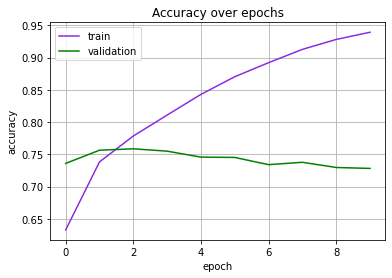

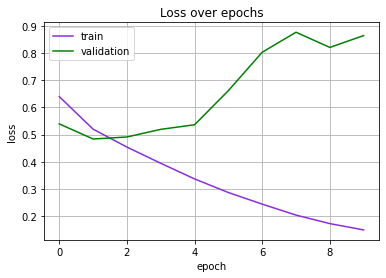

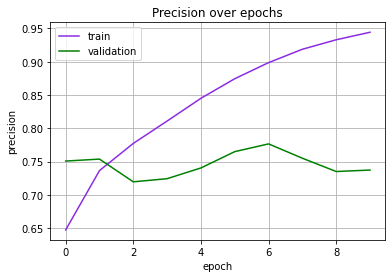

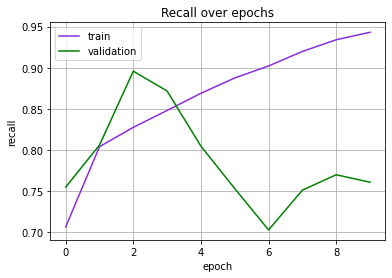

In [ ]:

log_data = pd.read_csv(f"/content/{MODEL_FILE_NAME}.log", sep=",", engine="python")
display_train_report_and_f1_score(log_data)
plot_train_data(log_data, train_metric="accuracy", validation_metric="val_accuracy")
plot_train_data(log_data, train_metric="loss", validation_metric="val_loss")
plot_train_data(log_data, train_metric="precision", validation_metric="val_precision")
plot_train_data(log_data, train_metric="recall", validation_metric="val_recall")
plt.show()

In [1]:
predictions = model.predict(test_data)

for prediction in predictions:
    for index, pred_class in enumerate(prediction):
        if pred_class > 0.8:
            prediction[index] = 1
        else:
            prediction[index] = 0
            
print("Classification with 0.8 prediction threshold")
print(f"\n{classification_report(test_labels, predictions)}")

NameError: ignored